In [113]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

from itertools import product

np.random.seed(15)
torch.manual_seed(15)

In [155]:
a1 = 0.4
b1 = 0.15
alpha1 = np.pi / 6
x0_1 = 0
y0_1 = 0

a2 = 0.7
b2 = 0.5
alpha2 = 0
x0_2 = 0
y0_2 = 0

a3 = 1
b3 = 1
alpha3 = 0
x0_3 = 0
y0_3 = 0

In [156]:

def f(alpha, x0, a, t, y0, b):
    return (x0 + a * np.cos(t)) * np.cos(alpha) + (y0 + b * np.sin(t)) * np.sin(alpha)

def g(alpha, x0, a, t, y0, b):
    return -(x0 + a * np.cos(t)) * np.sin(alpha) + (y0 + b * np.sin(t)) * np.cos(alpha)

In [157]:
t_set = np.arange(0, 2 * np.pi, 0.025)
t_0 = np.random.choice(t_set, size=60, replace=False)
t_1 = np.random.choice(t_set, size=100, replace=False)
t_2 = np.random.choice(t_set, size=120, replace=False)

In [158]:
x1 = f(alpha1, x0_1, a1, t_0, y0_1, b1)
y1 = g(alpha1, x0_1, a1, t_0, y0_1, b1)

x2 = f(alpha2, x0_2, a2, t_1, y0_2, b2)
y2 = g(alpha2, x0_2, a2, t_1, y0_2, b2)

x3 = f(alpha3, x0_3, a3, t_2, y0_3, b3)
y3 = g(alpha3, x0_3, a3, t_2, y0_3, b3)

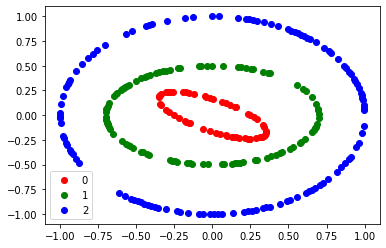

In [159]:


plt.scatter(x1, y1, color='r', label='0')
plt.scatter(x2, y2, color='g', label='1')
plt.scatter(x3, y3, color='b', label='2')
plt.legend()
plt.show()

Разделение на выборки

In [163]:
# 70-20-10 split
X_0 = np.vstack((x1, y1)).T
Y_0 = np.zeros(shape=(60,))
X_0_train, X_0_test, Y_0_train, Y_0_test = train_test_split(X_0, Y_0, test_size=0.3, random_state=13)
X_0_val, X_0_test, Y_0_val, Y_0_test = train_test_split(X_0_test, Y_0_test, test_size=0.33, random_state=13)

X_1 = np.vstack((x2, y2)).T
Y_1 = np.ones(shape=(100,))
X_1_train, X_1_test, Y_1_train, Y_1_test = train_test_split(X_1, Y_1, test_size=0.3, random_state=13)
X_1_val, X_1_test, Y_1_val, Y_1_test = train_test_split(X_1_test, Y_1_test, test_size=0.33, random_state=13)

X_2 = np.vstack((x3, y3)).T
Y_2 = 2 * np.ones(shape=(120,))
X_2_train, X_2_test, Y_2_train, Y_2_test = train_test_split(X_2, Y_2, test_size=0.3, random_state=13)
X_2_val, X_2_test, Y_2_val, Y_2_test = train_test_split(X_2_test, Y_2_test, test_size=0.33, random_state=13)

X_train = np.vstack((X_0_train, X_1_train, X_2_train))
Y_train = np.concatenate((Y_0_train, Y_1_train, Y_2_train))
X_val = np.vstack((X_0_val, X_1_val, X_2_val))
Y_val = np.concatenate((Y_0_val, Y_1_val, Y_2_val))
X_test = np.vstack((X_0_test, X_1_test, X_2_test))
Y_test = np.concatenate((Y_0_test, Y_1_test, Y_2_test))

In [164]:
class data(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).long()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.Y[idx]

train_loader = DataLoader(dataset=data(X_train, Y_train), shuffle=True, batch_size=32)
val_loader = DataLoader(dataset=data(X_val, Y_val), shuffle=False, batch_size=32)
test_loader = DataLoader(dataset=data(X_test, Y_test), shuffle=False, batch_size=1)

In [168]:
class feedforwardnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(2, 20)
        self.act = nn.ReLU()
        self.output = nn.Linear(in_features=20, out_features=3)

    def forward(self, x):
        x = self.hidden1(x)
        x = self.output(self.act(x))
        return x

model = feedforwardnet()
optimizer = torch.optim.Rprop(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

epochs = 1500
losses = []
total_correct = 0

for epoch in tqdm(range(epochs)):
    for d, l in train_loader:
        loss = criterion(model(d), l)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    for d, l in val_loader:
        Y_pred = torch.argmax(model(d), dim=1)
        is_correct = (Y_pred == l)
        total_correct += is_correct.sum()

    if epoch % 300 == 0:
        print(f'Val accuracy: {total_correct / len(val_loader.dataset)}')
        print(f'Loss: {losses[-1]}\n')

    total_correct = 0
    losses = []

  0%|          | 0/1500 [00:00<?, ?it/s]

Val accuracy: 0.3392857015132904
Loss: 1.2277841567993164

Val accuracy: 0.9642857313156128
Loss: 0.10291161388158798

Val accuracy: 0.9821428656578064
Loss: 0.08014015853404999

Val accuracy: 0.9642857313156128
Loss: 0.32744300365448

Val accuracy: 0.9642857313156128
Loss: 0.1410696804523468



In [150]:
Y_pred = []
for d, l in test_loader:
    Y_pred.append(np.argmax(torch.squeeze(model(d), dim=0).tolist()))

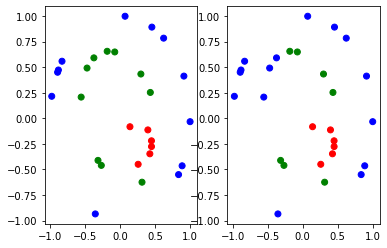

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2)
colors = []
for val in Y_test:
    if val == 0:
        colors.append('red')
    elif val == 1:
        colors.append('green')
    else:
        colors.append('blue')
ax1.scatter(X_test[:,0], X_test[:,1], color=colors)

colors = []
for val in Y_pred:
    if val == 0:
        colors.append('red')
    elif val == 1:
        colors.append('green')
    else:
        colors.append('blue')
ax2.scatter(X_test[:,0], X_test[:,1], color=colors)

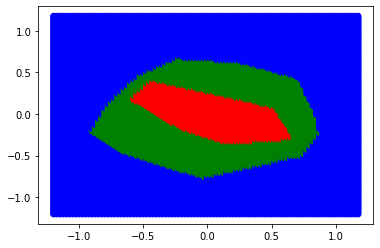

In [151]:
x = np.arange(-1.2, 1.2, 0.025)
combs = np.array(list(product(x, x)))

class test_dataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :]

comb_loader = DataLoader(dataset=test_dataset(combs))

Y_pred = []
for d in comb_loader:
    Y_pred.append(np.argmax(torch.squeeze(model(d), dim=0).tolist()))

colors = []
for val in Y_pred:
    if val == 0:
        colors.append('red')
    elif val == 1:
        colors.append('green')
    else:
        colors.append('blue')

plt.scatter(combs[:,0], combs[:,1], color=colors)

In [193]:
!pip install neupy

     |████████████████████████████████| 226 kB 29.2 MB/s 
     |████████████████████████████████| 92.7 MB 26 kB/s 
     |████████████████████████████████| 367 kB 74.9 MB/s 
     |████████████████████████████████| 50 kB 9.1 MB/s 
     |████████████████████████████████| 3.2 MB 45.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.0:
      Successfully uninstalled tensorflow-2.6.0
  Attempting uninstall: progressbar2
    Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progre

In [214]:
from neupy import algorithms
from neupy.layers import Input, Tanh, Linear, Sigmoid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [356]:
h = 0.025
t = np.linspace(0, 5, int(5/0.025), endpoint=True)
x = np.sin(t**2 - 6*t + 3)

train_size = int(t.shape[0] * 0.9)
train_size

X_train = t[:train_size]
y_train = x[:train_size]

X_test = t[train_size:]
y_test = x[train_size:]

scaler_x = StandardScaler()
scaler_y = StandardScaler()
tmp_train_scaled_x = scaler_x.fit_transform(X_train[:, np.newaxis])
tmp_test_scaled_x = scaler_x.transform(X_test[:, np.newaxis])
tmp_train_scaled_y = scaler_y.fit_transform(y_train[:, np.newaxis])


**Задание 2**\
Метод первого порядка:\
 Метод сопряженных градиентов.

In [357]:

lmnet = algorithms.ConjugateGradient((Input(1), Tanh(20), Linear(1)), verbose=True)



Main information

[ALGORITHM] ConjugateGradient

[OPTION] epsilon = 1e-07
[OPTION] loss = mse
[OPTION] regularizer = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] signals = None
[OPTION] target = Tensor("placeholder/target/linear-40:0", shape=(?, 1), dtype=float32)
[OPTION] update_function = fletcher_reeves
[OPTION] verbose = True
[OPTION] wolfe_c1 = 0.0001
[OPTION] wolfe_c2 = 0.9
[OPTION] wolfe_maxiter = 20

[TENSORFLOW] Initializing Tensorflow variables and functions.
[TENSORFLOW] Initialization finished successfully. It took 27.95 seconds


In [358]:
lmnet.train(X_train, y_train, epochs=60)



#1 : [6 sec] train: 0.302542
#2 : [3 ms] train: 0.260393
#3 : [4 ms] train: 0.245279
#4 : [2 ms] train: 0.242816
#5 : [2 ms] train: 0.229807
#6 : [3 ms] train: 0.225865
#7 : [2 ms] train: 0.212974
#8 : [3 ms] train: 0.206123
#9 : [3 ms] train: 0.201651
#10 : [2 ms] train: 0.201217
#11 : [3 ms] train: 0.200132
#12 : [3 ms] train: 0.195290
#13 : [4 ms] train: 0.193973
#14 : [4 ms] train: 0.193443
#15 : [4 ms] train: 0.191307
#16 : [4 ms] train: 0.190805
#17 : [4 ms] train: 0.190076
#18 : [3 ms] train: 0.189338
#19 : [4 ms] train: 0.185663
#20 : [4 ms] train: 0.185739
#21 : [4 ms] train: 0.183995
#22 : [4 ms] train: 0.182984
#23 : [4 ms] train: 0.182579
#24 : [4 ms] train: 0.182417
#25 : [4 ms] train: 0.182334
#26 : [4 ms] train: 0.182261
#27 : [4 ms] train: 0.182142
#28 : [4 ms] train: 0.181862
#29 : [4 ms] train: 0.181091
#30 : [4 ms] train: 0.179615
#31 : [5 ms] train: 0.177590
#32 : [4 ms] train: 0.176195
#33 : [4 ms] train: 0.175566
#34 : [4 ms] train: 0.175355
#35 : [4 ms] train: 0.

RMSE = 0.4098534251321085


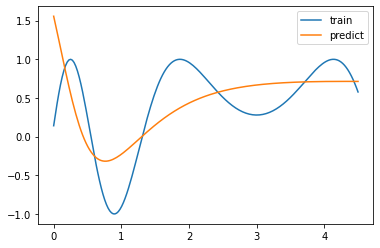

In [359]:

pred_x = lmnet.predict(X_train)
mse = mean_squared_error(y_train, pred_x.flatten())
print(f'RMSE = {np.sqrt(mse)}')

plt.plot(X_train, y_train, label='train')
plt.plot(X_train, pred_x, label='predict')
plt.legend();

plt.show()


RMSE = 1.0425874397569055


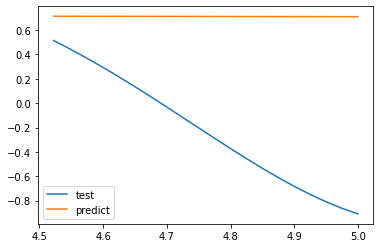

In [360]:

pred_x = lmnet.predict(X_test)
mse = mean_squared_error(y_test, pred_x.flatten())
print(f'RMSE = {np.sqrt(mse)}')

plt.plot(X_test, y_test, label='test')
plt.plot(X_test, pred_x, label='predict')
plt.legend();


plt.show()

**Задание 3**\
Метод второго порядка:

In [361]:

lmnet2 = algorithms.LevenbergMarquardt((Input(1), Tanh(20), Linear(1)), mu = 0.1, verbose=True)




Main information

[ALGORITHM] LevenbergMarquardt

[OPTION] loss = mse
[OPTION] mu = 0.1
[OPTION] mu_update_factor = 1.2
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] signals = None
[OPTION] target = Tensor("placeholder/target/linear-41:0", shape=(?, 1), dtype=float32)
[OPTION] verbose = True

[TENSORFLOW] Initializing Tensorflow variables and functions.
[TENSORFLOW] Initialization finished successfully. It took 30.55 seconds


In [362]:
lmnet2.train(X_train, y_train, epochs=60)

#1 : [6 sec] train: 0.355722


#2 : [449 ms] train: 1.384301
#3 : [13 ms] train: 0.360814
#4 : [19 ms] train: 0.196514
#5 : [12 ms] train: 0.114613
#6 : [12 ms] train: 0.130905
#7 : [11 ms] train: 0.124949
#8 : [12 ms] train: 0.050209
#9 : [12 ms] train: 0.507707
#10 : [12 ms] train: 0.131653
#11 : [11 ms] train: 0.129104
#12 : [18 ms] train: 0.733558
#13 : [12 ms] train: 0.103658
#14 : [12 ms] train: 0.035935
#15 : [12 ms] train: 0.516296
#16 : [12 ms] train: 1.049818
#17 : [11 ms] train: 1.102096


#18 : [17 ms] train: 0.549210
#19 : [14 ms] train: 0.162636
#20 : [11 ms] train: 0.042746
#21 : [12 ms] train: 0.012640
#22 : [16 ms] train: 0.008821
#23 : [12 ms] train: 0.005693
#24 : [12 ms] train: 0.005642
#25 : [12 ms] train: 0.005471
#26 : [12 ms] train: 0.005559
#27 : [12 ms] train: 0.005596
#28 : [11 ms] train: 0.005602
#29 : [12 ms] train: 0.005594
#30 : [11 ms] train: 0.005597
#31 : [12 ms] train: 0.005577
#32 : [12 ms] train: 0.005558
#33 : [12 ms] train: 0.005519
#34 : [11 ms] train: 0.005469


#35 : [16 ms] train: 0.005406
#36 : [11 ms] train: 0.005329
#37 : [11 ms] train: 0.005234
#38 : [11 ms] train: 0.005122
#39 : [11 ms] train: 0.004999
#40 : [11 ms] train: 0.004871
#41 : [11 ms] train: 0.004749
#42 : [11 ms] train: 0.004780
#43 : [11 ms] train: 0.005771
#44 : [12 ms] train: 0.010228
#45 : [11 ms] train: 0.004439
#46 : [13 ms] train: 0.003882
#47 : [11 ms] train: 0.002103
#48 : [10 ms] train: 0.002663
#49 : [11 ms] train: 0.001628
#50 : [11 ms] train: 0.001460
#51 : [11 ms] train: 0.001307
#52 : [11 ms] train: 0.001169
#53 : [10 ms] train: 0.001057
#54 : [15 ms] train: 0.000958
#55 : [10 ms] train: 0.000881
#56 : [10 ms] train: 0.000814
#57 : [13 ms] train: 0.000760
#58 : [10 ms] train: 0.000715
#59 : [11 ms] train: 0.000679
#60 : [10 ms] train: 0.000650


RMSE = 0.02509954806350635


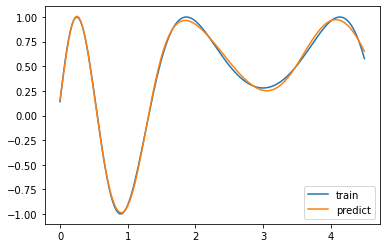

In [363]:

pred_x = lmnet2.predict(X_train)
mse = mean_squared_error(y_train, pred_x.flatten())
print(f'RMSE = {np.sqrt(mse)}')

plt.plot(X_train, y_train, label='train')
plt.plot(X_train, pred_x, label='predict')
plt.legend();

plt.show()

RMSE = 0.48057248246774226


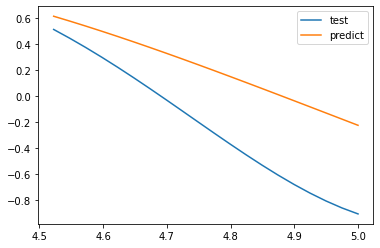

In [364]:

pred_x = lmnet2.predict(X_test)
mse = mean_squared_error(y_test, pred_x.flatten())
print(f'RMSE = {np.sqrt(mse)}')

plt.plot(X_test, y_test, label='test')
plt.plot(X_test, pred_x, label='predict')
plt.legend();


plt.show()